# Fabricating the data

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


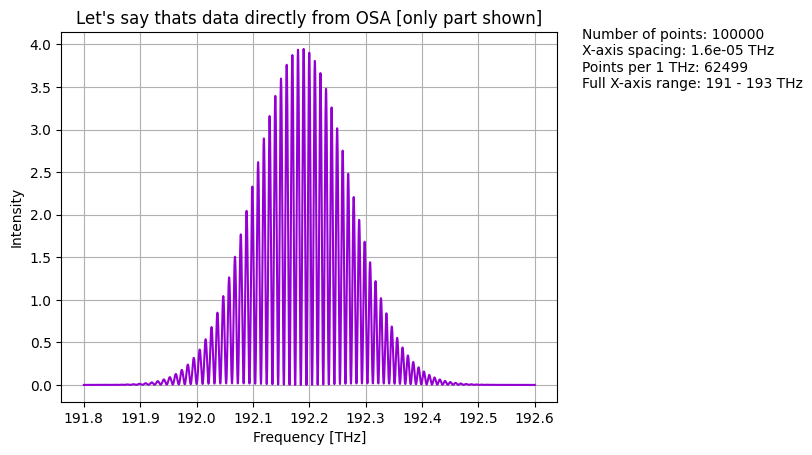

In [1]:
import spectral_analysis as sa
import pandas as pd
import numpy as np
from math import floor as flr
import matplotlib.pyplot as plt

# pulse function

def gaussian(omega, mu, sig):
    return np.exp(-np.power(omega - mu, 2.) / (2 * np.power(sig, 2.)))

def phase(omega, mu, fiber_length):
    return 2.17/2*(omega-mu)**3*fiber_length

def pulse(omega, mu, sig, fiber_length):
    return gaussian(omega, mu, sig)*np.exp(1j * phase(omega, mu, fiber_length))

pulse = np.vectorize(pulse)
gaussian = np.vectorize(gaussian)

# meta

mean = 192.2
sd = 0.12

time_delay = 100
shear = 1/75*2 # shear 0.1 nm
fiber = 1000

# OSA spectrum

line = np.linspace(191.4, 193, 100000)
integrate_interval = flr(shear/(line[1]-line[0]))

y = pulse(line + shear, mean, sd, fiber)*np.exp(1j*time_delay*line*2*np.pi) + pulse(line, mean, sd, fiber)
y = y * np.conjugate(y)

# noise

if False: 

    offset = pulse(line, mean, sd, 0)*np.conjugate(pulse(line, mean, sd, 0))*(np.sin(line*2*np.pi/0.1)+1.5)*0.5
    y += offset

    random_noise = pulse(line, mean, sd, 0)*np.random.uniform(high = 1, size = len(line))
    y += random_noise

# plot OSA

spider_spectrum = pd.DataFrame(np.transpose(np.stack([line, y])))
sa.plot(spider_spectrum, type = "freq", title = "Let's say thats data directly from OSA", min = 191.8, max = 192.6)

# amplitude of initial pulse

init_pulse = pd.DataFrame(np.transpose(np.stack([line, pulse(line, mean, sd, fiber)])))
#sa.plot(init_pulse, title = "Initial pulse amplitude", type = "freq")

# initial phase

ph = np.angle(pulse(line, mean, sd, fiber))
ph = np.unwrap(ph)
init_phase = pd.DataFrame(np.transpose(np.stack([line, ph])))

min_phase = sa.quantile(init_pulse, 0.025)
max_phase = sa.quantile(init_pulse, 0.975)

idx = np.searchsorted(init_phase.values[:, 0], 192.2)
init_phase.values[:,1] -= init_phase.values[idx,1]

# sa.plot(init_phase, title = "Initial spectral phase", color = "orange", min = min_phase, max = max_phase, what_to_plot = "real")

# pulse in time

time_pulse = sa.recover_pulse(init_phase, init_pulse)
# sa.plot(time_pulse, type = "time", min = -50, max = 100, color = "red", title = "Pulse shape")

# Applying the SPIDER

In [2]:
import spectral_analysis as sa

new_phase = sa.spider(phase_spectrum = spider_spectrum, 
       intensity_spectrum = init_pulse, 
       shear = shear, 
       spectrum_in = "freq", 
       what_to_return = "phase", 
       plot_steps = False,
       plot_phase = False,
       plot_pulse = False)[1]

new_pulse = sa.spider(phase_spectrum = spider_spectrum, 
       intensity_spectrum = init_pulse, 
       shear = shear, 
       spectrum_in = "freq", 
       what_to_return = "pulse", 
       plot_steps = False,
       plot_phase = False,
       plot_pulse = False)

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\spectral_analysis.py:715: ComplexWarning: Casting complex values to real discards the imaginary part
  integrate_interval = flr(shear/(np.mean(np.diff(s_freq.values[:, 0]))))


# Comparing results to "reality"

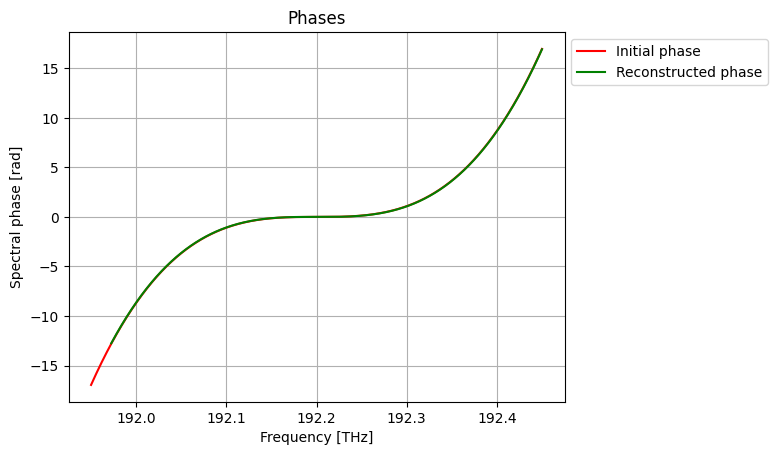

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


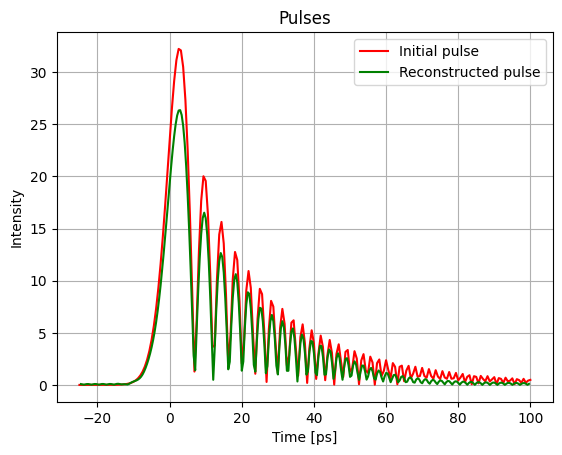

In [3]:
sa.compare_plots([init_phase, new_phase], 
                 title = "Phases", 
                 y_type = "phase", 
                 x_type = "freq", 
                 start = 191.95, 
                 end = 192.45, 
                 legend = ["Initial phase", "Reconstructed phase"])

sa.compare_plots([time_pulse, new_pulse], 
                 title = "Pulses", 
                 y_type = "int", 
                 x_type = "time", 
                 start = -25, 
                 end = 100, 
                 legend = ["Initial pulse", "Reconstructed pulse"], 
                 abs = True)